In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Definition of the Strategy class with functions to calculate performance indicators and a function to plot the PNL of a strategy over time.

class Strategy:

    def __init__(self, name, returns, initial_wealth):
        self.name = name
        self.returns = returns
        self.pnl = np.c_[np.array([initial_wealth]), initial_wealth * np.cumprod(1. + returns.to_numpy()).reshape(1, -1)].flatten()

    def volatility(self):
        return np.std(self.returns) * np.sqrt(252)

    def sharpe_ratio(self):
        return np.mean(self.returns) * np.sqrt(252) / np.std(self.returns)

    def max_dd(self):
        return 1. - np.min(np.flip(np.minimum.accumulate(np.flip(self.pnl)))/self.pnl)

    def max_dd_2(self):
        return np.max(1. - self.pnl / np.maximum.accumulate(self.pnl))

    def illustrate(self):
        fig, ax = plt.subplots(1, 1)
        ax.plot(self.returns.index, self.pnl[1:], 'b', label=self.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)'%(self.volatility(), self.sharpe_ratio(), self.max_dd()))
        ax.set_xlabel('Time')
        ax.set_ylabel('PnL')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'PnL of the strategy {self.name}')
        ax.grid(axis='x', linestyle='--')
        fig.tight_layout()
        fig.savefig(f'{self.name}.pdf')
        plt.show()

# In this class, three sub-classes are created (inheritance), corresponding to the three different portfolio strategies.

class EqWeighted(Strategy):

    def __init__(self, name, returns, initial_wealth):
        weights_EW = [1/returns.shape[1] for i in range(returns.shape[1])]
        returns_EW = ((returns * weights_EW).sum(axis=1))
        super().__init__(name, returns_EW, initial_wealth)
        
class MMVWeighted(Strategy):

    def __init__(self, name, returns, cov_matrix, initial_wealth): 
        # Constraint for the sum of weights equal to 1
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        # Constraint for the weights of assets between 0 and 1
        bounds = tuple((0, 1) for i in range(returns.shape[1]))
        # Initial weights initialization
        initial_weights = [1/returns.shape[1] for i in range(returns.shape[1])]
        # Optimization to minimize the portfolio variance using the minimize function
        result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
        # Optimal weights are found in result.x
        weights_MMV = result.x
        returns_MMV = ((returns * weights_MMV).sum(axis=1))
        super().__init__(name, returns_MMV, initial_wealth)
        
class ERCWeighted(Strategy):

    def __init__(self, name, returns, cov_matrix, initial_wealth): 
        # Constraint for the sum of weights equal to 1
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        # Constraint for the weights of assets between 0 and 1
        bounds = tuple((0, 1) for i in range(returns.shape[1]))
        # Initial weights initialization
        initial_weights = [1/returns.shape[1] for i in range(returns.shape[1])]
        # Optimization to minimize the standard deviation of risk contribution for each asset using the minimize function
        result = minimize(risk_contribution, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
        # Optimal weights are found in result.x
        weights_ERC = result.x
        returns_ERC = ((returns * weights_ERC).sum(axis=1))
        super().__init__(name, returns_ERC, initial_wealth)

In [43]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize

# data cleaning step

Raw_Data = pd.read_excel('https://www.oliviergueant.com/uploads/4/3/0/9/4309511/sbf120_as_of_end_2018.xlsx', sheet_name = 'Data')

df_mkt_cap_list = []
for i in range(120):
    mkt_cap_data = Raw_Data.iloc[:,[3*i,3*i+2]].copy()
    mkt_cap_data.dropna(inplace = True)
    mkt_cap_data.iloc[:,0] = pd.to_datetime(mkt_cap_data.iloc[:,0], unit= 'D', origin= '1899-12-30')
    mkt_cap_data.rename(columns = {mkt_cap_data.columns[0] : 'Date', mkt_cap_data.columns[1]: mkt_cap_data.columns[0]}, inplace = True)
    mkt_cap_data.set_index('Date', inplace = True)
    df_mkt_cap_list.append(mkt_cap_data)

agg_mkt_cap_data = df_mkt_cap_list[0]

for df in (df_mkt_cap_list[1:]):
    agg_mkt_cap_data = agg_mkt_cap_data.join(df, how='outer', sort = True)

# 10 highest market cap 

agg_mkt_cap_dataT=agg_mkt_cap_data.T
agg_mkt_cap_dataT=agg_mkt_cap_dataT.nlargest(10,'31/12/2018')    
agg_mkt_cap_data=agg_mkt_cap_dataT.T

agg_mkt_cap_data = agg_mkt_cap_data[(agg_mkt_cap_data.index >= '31/12/2018') & (agg_mkt_cap_data.index <= '31/12/2019')].copy()

for ticker in (agg_mkt_cap_data.columns):
    if agg_mkt_cap_data[ticker].isnull().values.any():
        nulls = agg_mkt_cap_data[ticker].isnull()

price_df_list = []
for i in range(120):
    price_data= Raw_Data.iloc[:,3*i:3*i+2].copy()
    price_data.dropna(inplace=True) # drop the NA (not a number)
    price_data.iloc[:,0] = pd.to_datetime(price_data.iloc[:,0], unit='D', origin='1899-12-30')
    price_data.rename(columns={price_data.columns[0] : 'Date', price_data.columns[1]:price_data.columns[0]}, inplace=True)
    price_data.set_index('Date', inplace=True)
    price_df_list.append(price_data)

agg_price_data = price_df_list[0]
for df in (price_df_list[1:]):
    agg_price_data= agg_price_data.join(df, how='outer', sort= True)


for ticker in agg_price_data.columns:
    if ticker in agg_mkt_cap_data.columns:
        series = agg_price_data[ticker]
        first = series.first_valid_index()
        last = series.last_valid_index()
        series_real = series[(series.index >= first) & (series.index <= last)].fillna(method = 'bfill')
        agg_price_data[ticker][(agg_price_data[ticker].index >= first) & (agg_price_data[ticker].index <= last)] = series_real
    else:
        del agg_price_data[ticker]
        agg_price_data.head()

agg_price_data1 = agg_price_data[(agg_price_data.index >= '31/12/2018') & (agg_price_data.index <= '31/12/2019')].copy()

agg_price_data2 = agg_price_data[(agg_price_data.index >= '31/12/2016') & (agg_price_data.index <= '31/12/2018')].copy()

# for strategies
returns1= agg_price_data1.pct_change().dropna()
# for covariance matrix generation
returns2= agg_price_data2.pct_change().dropna()

# defining covariance matrix in the period 2017-2018
cov_matrix=[]
cov_matrix=returns2.cov()

# Function to minimize for the Markowitz Minimum Variance method

def portfolio_variance(weights, cov_matrix):
    # Portfolio variance calculation: We multiply the covariance matrix by 100 since we observed through testing that the minimization doesn't work well if the values in the matrix are too small
    portfolio_variance = np.dot(weights, np.dot(cov_matrix*100, weights.T))
    return portfolio_variance

# Function to minimize for the ERC method

def risk_contribution(weights, cov_matrix):
    # Calculation of MCR (Marginal Contribution to Risk) for each asset
    mcr = np.dot(cov_matrix*100, weights.T) / np.sqrt(np.dot(weights, np.dot(cov_matrix*100, weights.T)))
    # Risk contribution is the MCR vector weighted by the weight of each asset
    risk_contribution=weights*mcr
    # For the ECR method, we aim to minimize the standard deviation of our risk_contribution vector
    return np.std(risk_contribution)

# initial weight value, has to be set by the user
initial_weight=10**6

C:\Users\biraw\anaconda3\lib\site-packages\pandas\core\frame.py:3471: UserWarning: Parsing '31/12/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  if self.columns.is_unique and key in self.columns:
C:\Users\biraw\anaconda3\lib\site-packages\pandas\core\frame.py:3474: UserWarning: Parsing '31/12/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._get_item_cache(key)
C:\Users\biraw\anaconda3\lib\site-packages\pandas\core\arraylike.py:60: UserWarning: Parsing '31/12/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.ge)
C:\Users\biraw\anaconda3\lib\site-packages\pandas\core\arraylike.py:52: UserWarning: Parsing '31/12/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.le)
C:\U

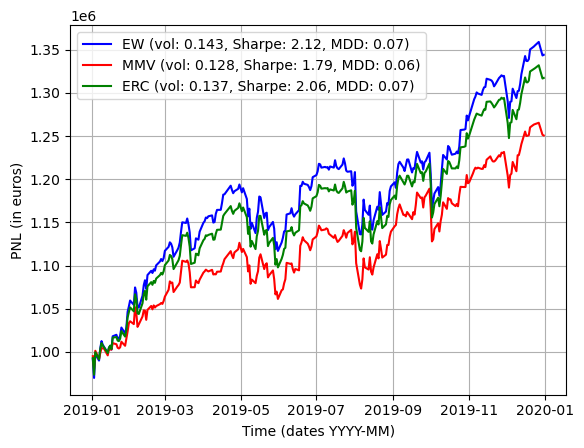

In [44]:
# compute strategies
ew_port = EqWeighted('EW', returns1, initial_weight)
mmv_port=MMVWeighted('MMV', returns1, cov_matrix, initial_weight)
erc_port=ERCWeighted('ERC', returns1, cov_matrix, initial_weight)

# plot all strategies in one figure
plt.figure()
plt.plot(ew_port.returns.index, ew_port.pnl[1:], 'b', label=ew_port.name + ' (vol: %.3f, Sharpe: %.2f, MDD: %.2f)'%(ew_port.volatility(), ew_port.sharpe_ratio(), ew_port.max_dd()))
plt.plot(mmv_port.returns.index, mmv_port.pnl[1:], 'r', label=mmv_port.name + ' (vol: %.3f, Sharpe: %.2f, MDD: %.2f)'%(mmv_port.volatility(), mmv_port.sharpe_ratio(), mmv_port.max_dd()))
plt.plot(erc_port.returns.index, erc_port.pnl[1:], 'g', label=erc_port.name + ' (vol: %.3f, Sharpe: %.2f, MDD: %.2f)'%(erc_port.volatility(), erc_port.sharpe_ratio(), erc_port.max_dd()))
plt.grid(True)
plt.legend(loc=0)
plt.xlabel("Time (dates YYYY-MM)")
plt.ylabel('PNL (in euros)')
plt.show()
